In [1]:
import platform
platform.uname()  # get the information of this computer system

uname_result(system='Windows', node='DESKTOP-EDGLTRS', release='10', version='10.0.18362', machine='AMD64', processor='Intel64 Family 6 Model 142 Stepping 10, GenuineIntel')

In [2]:
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10

### Set the configurations.

In [3]:
%matplotlib inline
# rc = runtime configuration, run at startup and configure the stuff
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
'''
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
'''

# the notebook will reload external python modules
# if we called the import function such as load_CIFAR10() in this case, then we want to change the content of the function,
# we can just change it in the cs231n.data_utils module, and the IPython will reload the changed module automatically, 
# which means we do not need to reload the module manually again.
# (see more details in http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

### Load the raw CIFAR-10 data.

In [4]:
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Visualize the CIFAR-10 data.

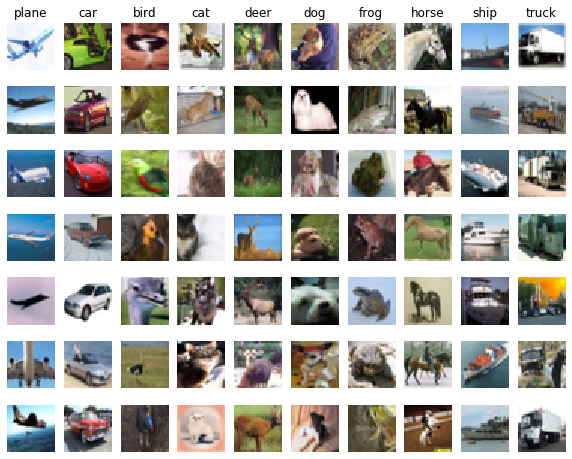

In [5]:
# Visualize some examples from the dataset.
# Show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y) # np.flatnonzero: return the position of non-zero values after flatting the array
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx) # pyplot.subplot(nrows, ncols, index)
                                                             # index denotes as position of the current subplot,
                                                             # the position of the whole plot is row-major.
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Subsample dataset: 5000 for training, 500 for testing.

In [6]:
# Subsample the data for more efficient code execution
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1)) # numpy.reshape(item, new_shape)
                                                      # new_shape = (rows, -1) means the unspecified value "cols"
                                                      # is inferred to be (dimension/rows)
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


### Build and train the KNN classifier.

In [7]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

#### compute_distances_two_loops

In [8]:
# Test implementation of function "compute_distances_two_loops" in cs231n/classifiers/k_nearest_neighbor.py.
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


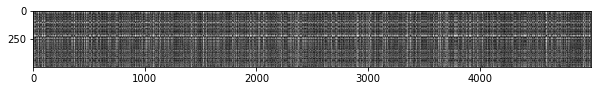

In [9]:
# Visualize the distance matrix: each row is a single test example and its distances to training examples.
# Some rows or columns are visible brighter, which looks like white color.
# Black indicates low distances while white indicates high distances.
plt.imshow(dists, interpolation='none')
plt.show()

In [10]:
# Implement the function predict_labels with k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples.
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [11]:
# Implement the function predict_labels with k = 5 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=5)

# Compute and print the fraction of correctly predicted examples.
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


#### compute_distances_one_loop

In [12]:
# Speed up distance matrix computation by using partial vectorization with one loop.
# Implement the function compute_distances_one_loop.
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. The 
# Frobenius norm of two matrices is the square root of the squared sum of 
# differences of all elements; in other words, reshape the matrices into vectors
# and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


#### compute_distances_no_loops

In [13]:
# Implement the fully vectorized version inside compute_distances_no_loops.
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [14]:
# Compare how fast the implementations are.
def time_function(f, *args): # variable number of non-keyworded, variable-length arguments passed to a function
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

Two loop version took 81.436664 seconds
One loop version took 145.428619 seconds
No loop version took 0.505193 seconds


### Determine the best value of hyperparameter k with cross-validation.

In [15]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds = np.split(X_train, num_folds) # numpy.split() splits array into N segments, stored in a list,
y_train_folds = np.split(y_train, num_folds) # the list has N arrays

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for k in k_choices:
    k_to_accuracies[k] = []
    for i in range(num_folds):
        # take out the i-th fold as validation set
        train_set = np.vstack(X_train_folds[:i] + X_train_folds[i+1:])
        label_set = np.hstack(y_train_folds[:i] + y_train_folds[i+1:])
        
        # run the k-nearest-neighbor algorithm
        classifier.train(train_set, label_set)
        pred = classifier.predict(X_train_folds[i], k=k, num_loops=0)
        
        # calculate the accuracy of i-th fold
        correct = np.sum(y_train_folds[i] == pred)
        accuracy = correct / y_train_folds[i].shape[0]
        
        k_to_accuracies[k].append(accuracy)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

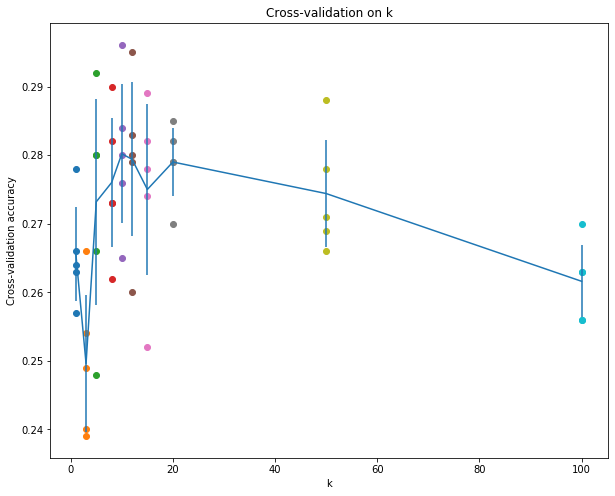

In [16]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(x=k_choices, y=accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [17]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
